# Load data

In [5]:
import pandas as pd

hit_file = "../ml/processed_events/normalized_features.parquet"
train_data = pd.read_parquet(hit_file)

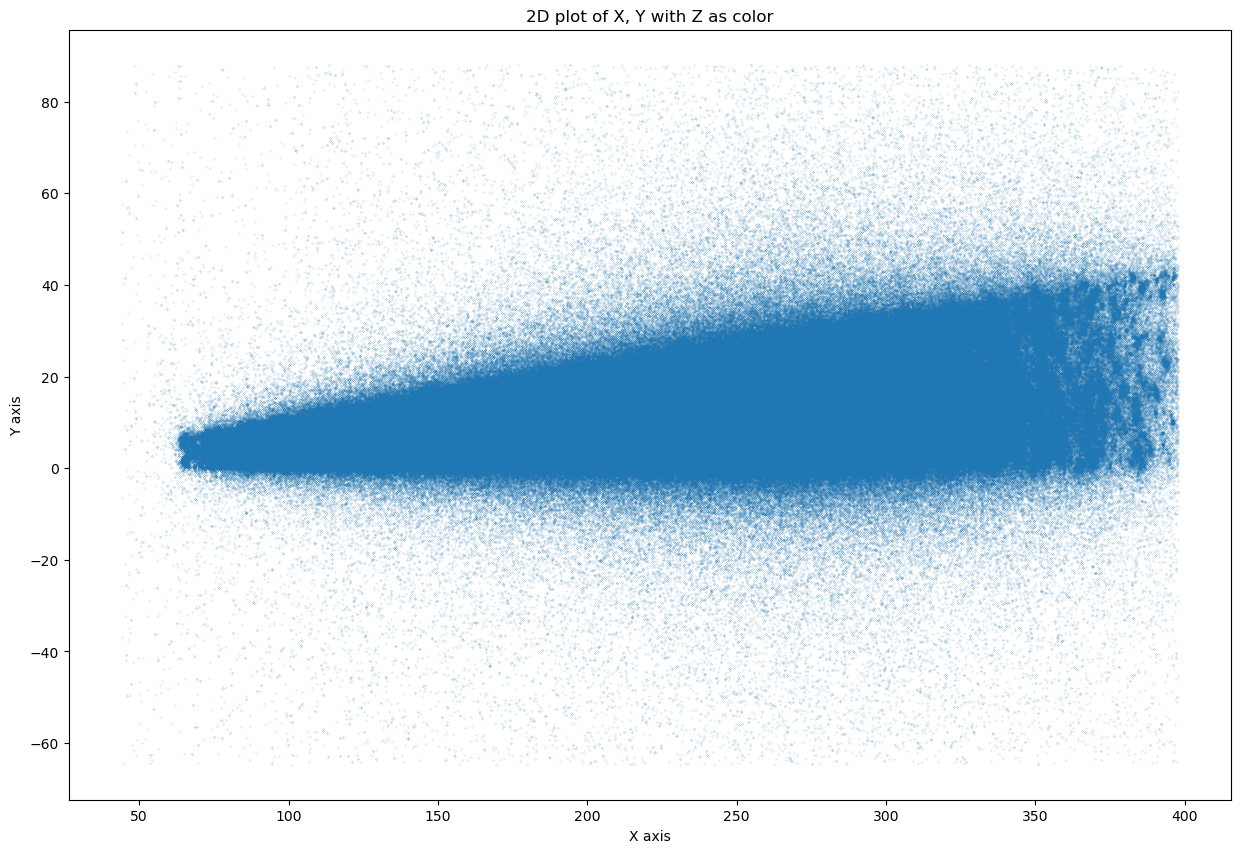

In [6]:
# 2d plot of x,y z, transfomed to 2d, from train_data
import matplotlib.pyplot as plt
import numpy as np

# Create a 2D scatter plot
figure, ax = plt.subplots(figsize=(15, 10))
plt.scatter(train_data['X_transformed'].values, train_data['Y_transformed'].values, s=0.01)
plt.xlabel('X axis')
plt.ylabel('Y axis')
# plt.xlim(-3, 3)
# plt.ylim(-2, 2)
plt.title('2D plot of X, Y with Z as color')
plt.show()


## Plot histograms of all columns

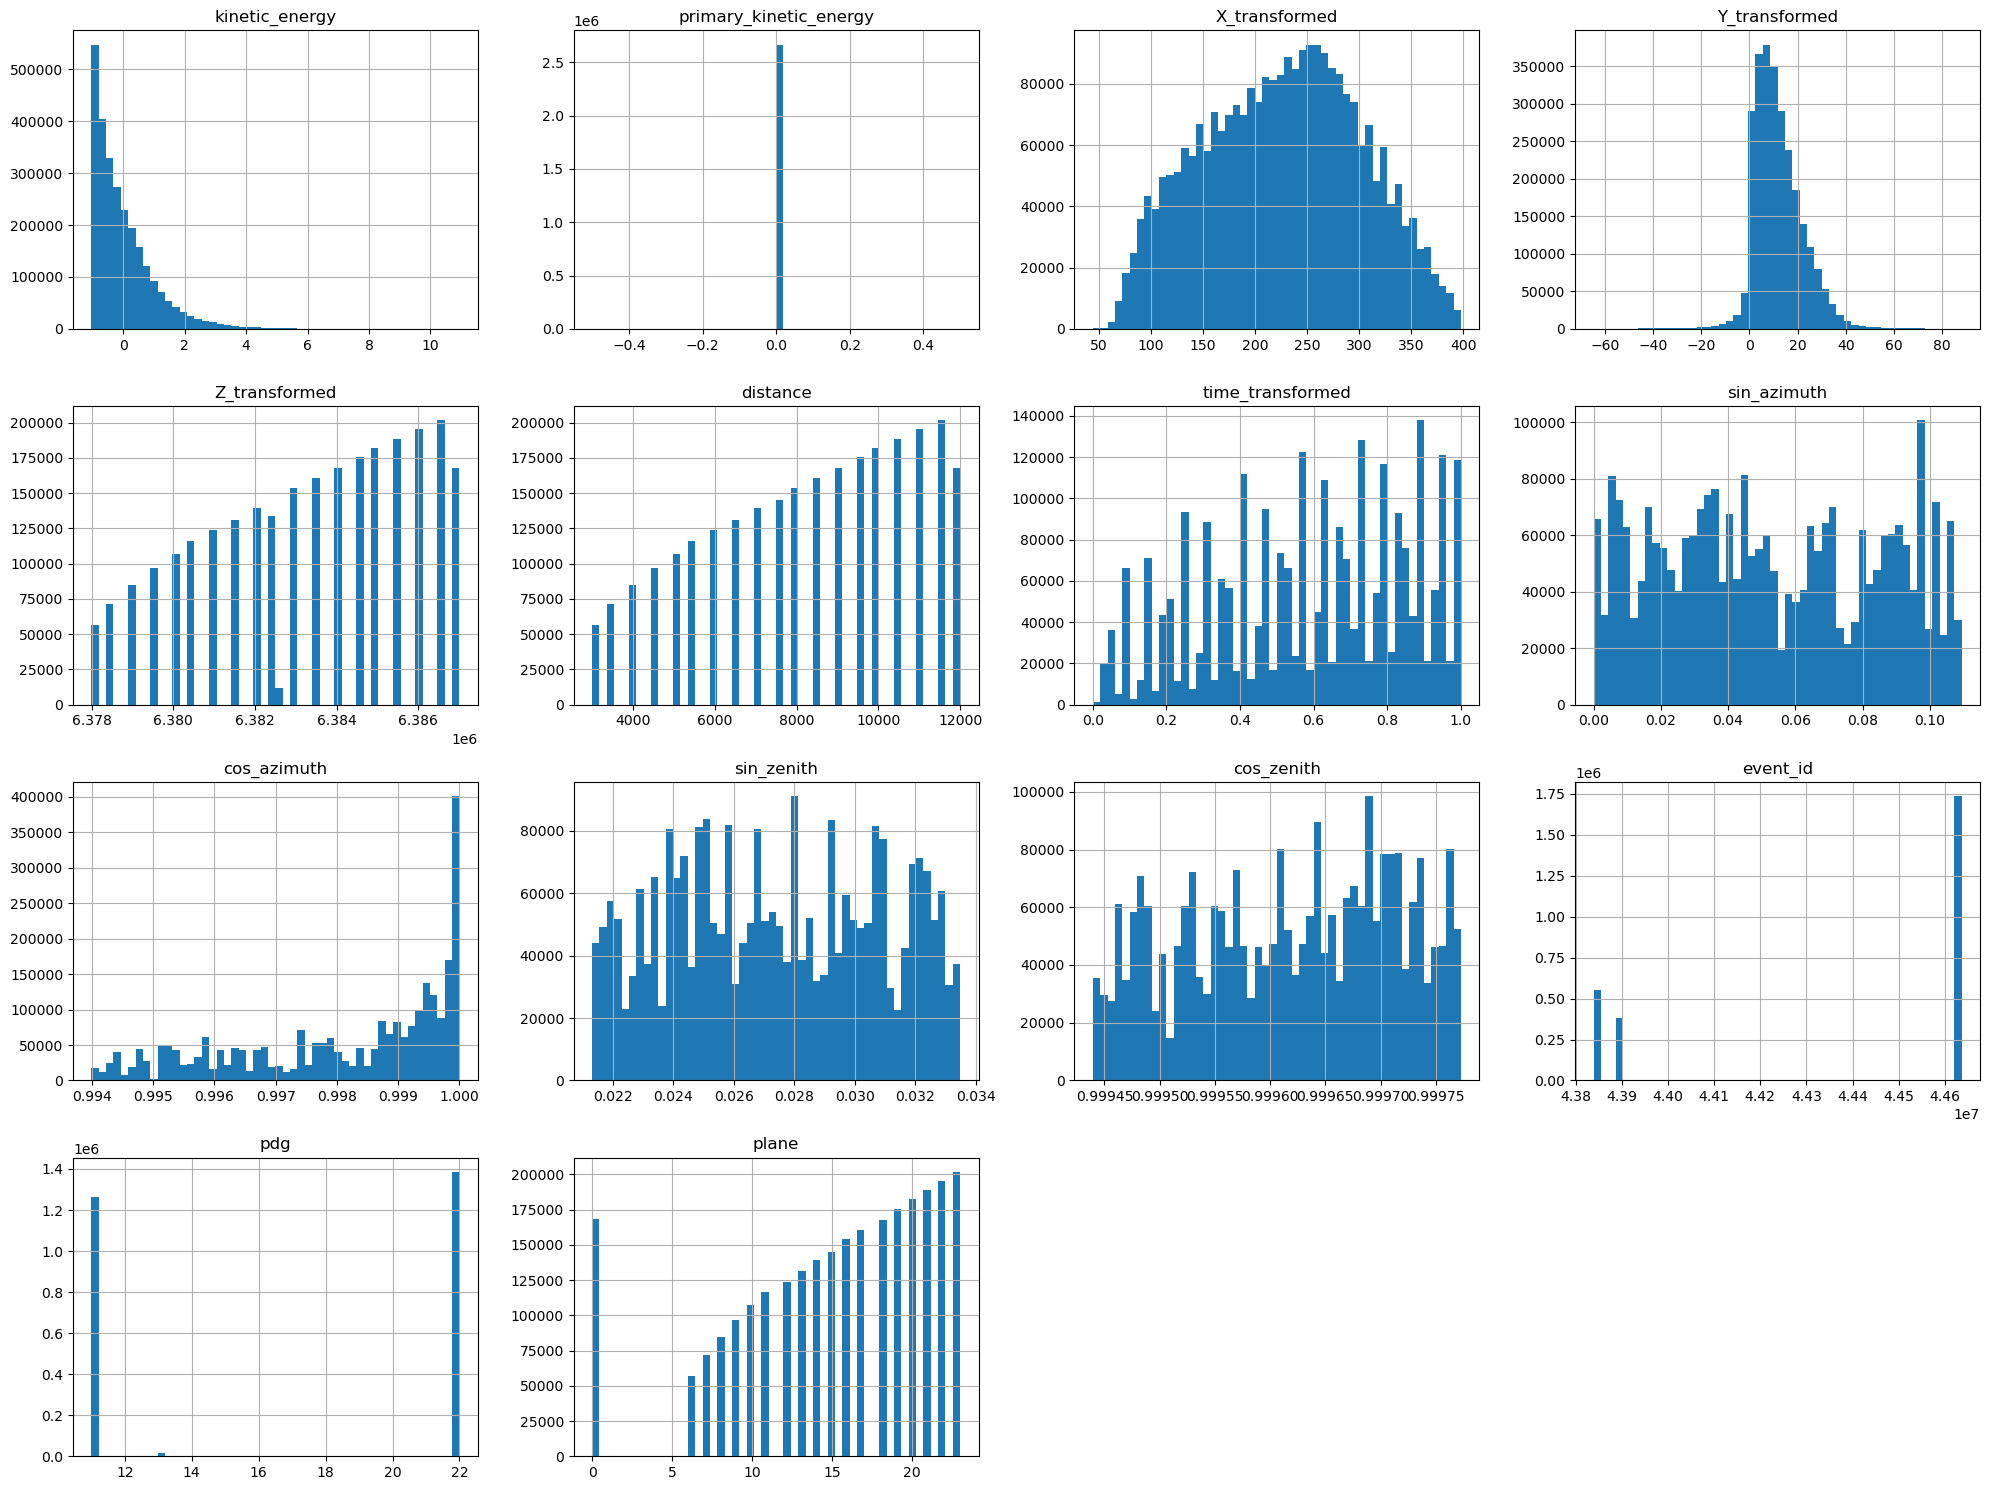

In [7]:
# plot histograms of each feature
import matplotlib.pyplot as plt
train_data.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()


## Plot statistics for events

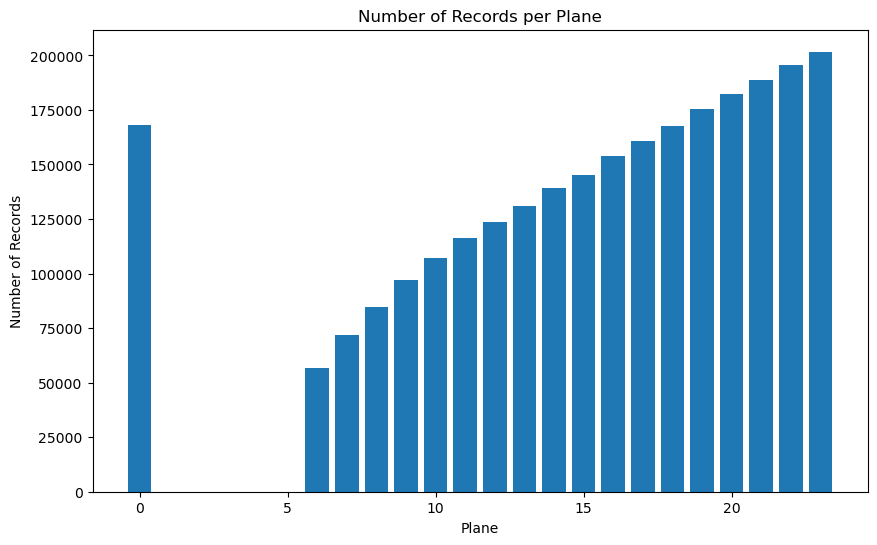

In [10]:
# count records per plane
records_per_plane = train_data.groupby('plane').size().reset_index(name='num_records')
# plot historgram of records per plane
plt.figure(figsize=(10,6))
plt.bar(records_per_plane['plane'], records_per_plane['num_records'])
plt.xlabel('Plane')
plt.ylabel('Number of Records')
plt.title('Number of Records per Plane')
plt.show()

In [37]:
# select top 10 event with most records
max_records_events = train_data.groupby('event_id').size().nlargest(10).index
print(f"Events with most records: {max_records_events}")

max_records_event = max_records_events[0]

Events with most records: Index([43888008.0, 43888065.0, 44634388.0, 44635212.0, 44634225.0, 43845485.0,
       43888348.0, 43887992.0, 44633576.0, 44633579.0],
      dtype='float64', name='event_id')


In [38]:
# 3d plot all x,y,z transformed for the event with most records
top_event_data = train_data[train_data['event_id'] == max_records_event]

In [45]:
top_event_data['plane'].unique()
# save only data from plane 0 

# change plane number 0 to 24 for all reccords in top_event_data after copying
top_event_data = top_event_data.copy()
top_event_data.loc[top_event_data['plane'] == 0, 'plane'] = 24

In [46]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time


def plot_cone(bottom_radius, tip_position, bottom_center, num_points=100):
    """
    Plot a 3D cone with customizable tip and bottom center positions.
    
    Parameters:
    -----------
    bottom_radius : float
        Radius of the cone's base
    tip_position : tuple or array
        (x_tip, y_tip, z_tip) coordinates of the cone's apex
    bottom_center : tuple or array
        (x_base, y_base, z_base) coordinates of the cone's base center
    num_points : int
        Resolution of the mesh (default: 100)
    """
    # Create figure and 3D axis
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Convert to numpy arrays
    tip = np.array(tip_position)
    base = np.array(bottom_center)
    
    # Calculate the axis vector (from tip to base center)
    axis_vector = base - tip
    height = np.linalg.norm(axis_vector)
    axis_unit = axis_vector / height
    
    # Create parametric grid
    theta = np.linspace(0, 2 * np.pi, num_points)
    h = np.linspace(0, height, num_points)
    Theta, H = np.meshgrid(theta, h)
    
    # Create perpendicular vectors for the circular cross-section
    # Find a vector perpendicular to the axis
    if abs(axis_unit[2]) < 0.9:
        perp1 = np.cross(axis_unit, np.array([0, 0, 1]))
    else:
        perp1 = np.cross(axis_unit, np.array([1, 0, 0]))
    perp1 = perp1 / np.linalg.norm(perp1)
    
    # Get second perpendicular vector
    perp2 = np.cross(axis_unit, perp1)
    perp2 = perp2 / np.linalg.norm(perp2)
    
    # Radius varies linearly from 0 at tip to bottom_radius at base
    R = (bottom_radius / height) * H
    
    # Generate points along the cone
    X = tip[0] + H * axis_unit[0] + R * (np.cos(Theta) * perp1[0] + np.sin(Theta) * perp2[0])
    Y = tip[1] + H * axis_unit[1] + R * (np.cos(Theta) * perp1[1] + np.sin(Theta) * perp2[1])
    Z = tip[2] + H * axis_unit[2] + R * (np.cos(Theta) * perp1[2] + np.sin(Theta) * perp2[2])
    
    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, color='red', alpha=0.2, 
                           edgecolor='none', antialiased=True)
    
    # Optional: Add base circle (cap)
    theta_cap = np.linspace(0, 2 * np.pi, num_points)
    x_cap = base[0] + bottom_radius * (np.cos(theta_cap) * perp1[0] + np.sin(theta_cap) * perp2[0])
    y_cap = base[1] + bottom_radius * (np.cos(theta_cap) * perp1[1] + np.sin(theta_cap) * perp2[1])
    z_cap = base[2] + bottom_radius * (np.cos(theta_cap) * perp1[2] + np.sin(theta_cap) * perp2[2])
    
    # Create triangulation for the base
    from matplotlib.tri import Triangulation
    r_cap = np.linspace(0, bottom_radius, 20)
    theta_cap_mesh, r_cap_mesh = np.meshgrid(theta_cap, r_cap)
    x_cap_mesh = base[0] + r_cap_mesh * (np.cos(theta_cap_mesh) * perp1[0] + np.sin(theta_cap_mesh) * perp2[0])
    y_cap_mesh = base[1] + r_cap_mesh * (np.cos(theta_cap_mesh) * perp1[1] + np.sin(theta_cap_mesh) * perp2[1])
    z_cap_mesh = base[2] + r_cap_mesh * (np.cos(theta_cap_mesh) * perp1[2] + np.sin(theta_cap_mesh) * perp2[2])
    ax.plot_surface(x_cap_mesh, y_cap_mesh, z_cap_mesh, color='blue', alpha=0.5)
    
    # Add labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title(f'3D Cone\nRadius: {bottom_radius:.2f}, Height: {height:.2f}\n' + 
                 f'Tip: {tuple(np.round(tip, 2))}, Base: {tuple(np.round(base, 2))}')
      
    # Set aspect ratio
    ax.set_box_aspect([1, 1, 1])
    
    # set limits
    ax.set_xlim([50, 350])
    ax.set_ylim([-100, 200])
    # ax.set_zlim([-2, 1.5])
    
    return fig, ax

In [57]:
def plot_cone_with_scatter(top_event_data, elev=10., azim=330.0):
    
    min_plane = top_event_data[top_event_data['plane'] > 0]['plane'].min()
    max_plane = top_event_data['plane'].max()
    
    # plot 3d cone here
    # get average x,y,z from plane 0
    avg_x_min = top_event_data[top_event_data['plane'] == min_plane]['X_transformed'].mean()
    avg_y_min = top_event_data[top_event_data['plane'] == min_plane]['Y_transformed'].mean()
    avg_z_min = top_event_data[top_event_data['plane'] == min_plane]['Z_transformed'].mean()

    # get average x, y, z from plane 24
    avg_x_max = top_event_data[top_event_data['plane'] == max_plane]['X_transformed'].mean()
    avg_y_max = top_event_data[top_event_data['plane'] == max_plane]['Y_transformed'].mean()
    avg_z_max = top_event_data[top_event_data['plane'] == max_plane]['Z_transformed'].mean()

    # radius is 3* l2 norm of std (x,y,z) at plane 24
    radius = 3*np.linalg.norm([
        top_event_data[top_event_data['plane'] == max_plane]['X_transformed'].std(),
        top_event_data[top_event_data['plane'] == max_plane]['Y_transformed'].std(),
        top_event_data[top_event_data['plane'] == max_plane]['Z_transformed'].std()
    ])

    fig, ax = plot_cone(
        bottom_radius=radius, 
        tip_position=(avg_x_min, avg_y_min, avg_z_min), 
        bottom_center=(avg_x_max, avg_y_max, avg_z_max)
    )
    
    # add scatter plot of the hits
    tmin = top_event_data['time_transformed'].min()
    tmax = top_event_data['time_transformed'].max()
    cmap = plt.get_cmap('viridis')

    # Scatter plot
    # plot 3d particle plot where x, y, z are X_transformed, Y_transformed, Z_transformed and color depends on kinetic energy
    sc = ax.scatter(
            top_event_data['X_transformed'], 
            top_event_data['Y_transformed'], 
            top_event_data['Z_transformed'],
            color=cmap((top_event_data["time_transformed"] - tmin) / (tmax - tmin)),
        )

    cbar = plt.colorbar(sc, label='Normalized Time', pad = 0.1, shrink=0.5)
    ax.set_xlabel('X_transformed')
    ax.set_ylabel('Y_transformed')
    ax.set_zlabel('Z_transformed')
    ax.view_init(elev=elev, azim=azim)

    return fig, ax


/tmp/ipykernel_2224/360001047.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plane_data['Y_transformed'] = plane_data['Y_transformed'].rolling(window=50).mean()


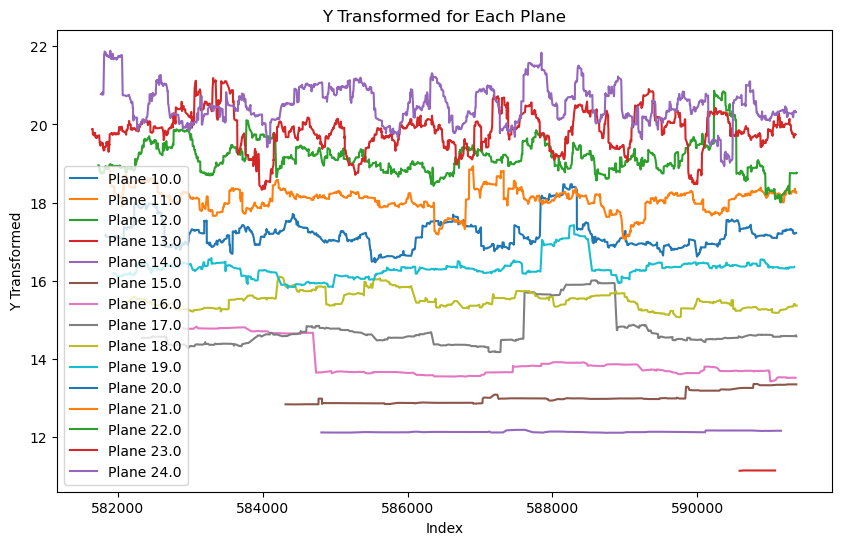

In [58]:
# plot y values plot foe each aplne ina sinel plot
plt.figure(figsize=(10,6))
for plane in sorted(top_event_data['plane'].unique()):
    plane_data = top_event_data[top_event_data['plane'] == plane]
    # smoothen
    plane_data['Y_transformed'] = plane_data['Y_transformed'].rolling(window=50).mean()
    plt.plot(plane_data['Y_transformed'], label=f'Plane {plane}')
plt.xlabel('Index')
plt.ylabel('Y Transformed')
# plt.ylim(-2.5, 2.5)
plt.title('Y Transformed for Each Plane')
plt.legend()
plt.show()  

In [60]:
# print mean values of y fro each palne
for plane in sorted(top_event_data['plane'].unique()):
    plane_data = top_event_data[top_event_data['plane'] == plane]
    mean_y = plane_data['Y_transformed'].mean()
    print(f'Plane {plane}: Mean Y Transformed = {mean_y:.4f}')

Plane 10.0: Mean Y Transformed = 8.5862
Plane 11.0: Mean Y Transformed = 9.4449
Plane 12.0: Mean Y Transformed = 10.3038
Plane 13.0: Mean Y Transformed = 11.1471
Plane 14.0: Mean Y Transformed = 12.1255
Plane 15.0: Mean Y Transformed = 13.0650
Plane 16.0: Mean Y Transformed = 13.8479
Plane 17.0: Mean Y Transformed = 14.6852
Plane 18.0: Mean Y Transformed = 15.4916
Plane 19.0: Mean Y Transformed = 16.3128
Plane 20.0: Mean Y Transformed = 17.1982
Plane 21.0: Mean Y Transformed = 18.1111
Plane 22.0: Mean Y Transformed = 19.1420
Plane 23.0: Mean Y Transformed = 19.8215
Plane 24.0: Mean Y Transformed = 20.5120


In [ ]:
# fig, ax = plot_cone_with_scatter(top_event_data, elev=15., azim=70.0)
# plt.show()
# save each frame as png and create animation later in a new folder
import os

output_folder = "cone_frames"
os.makedirs(output_folder, exist_ok=True)

for angle in range(0, 360, 5):
    fig, ax = plot_cone_with_scatter(top_event_data, elev=15., azim=angle)
    plt.savefig(os.path.join(output_folder, f'cone_frame_{angle:03d}.png'))
    plt.close(fig)
    
# create animation from the png files using imageio
import imageio
images = []
for angle in range(0, 360, 5):
    filename = os.path.join(output_folder, f'cone_frame_{angle:03d}.png')
    images.append(imageio.imread(filename))
imageio.mimsave(os.path.join(output_folder,'cone_animation.gif'), images, loop=0, fps=60)


/tmp/ipykernel_2185/3504303230.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [ ]:
fig, ax = plot_cone_with_scatter(top_event_data, elev=15., azim=90)
plt.show()

# Prepare training data

Select input and output columns

In [ ]:
import sklearn as sk
from sklearn.model_selection import train_test_split

input_columns = [
            "primary_kinetic_energy",
            "sin_azimuth", "cos_azimuth", "sin_zenith", "cos_zenith"
        ]
output_columns = [
            "kinetic_energy", 
            "X_transformed", "Y_transformed", "Z_transformed",
        ]
batch_identifier = "event_id"

Calculate meand and std of secondary features

In [ ]:
# select only plane 23
event_stats = train_data[train_data['plane'] == 23].reset_index(drop=True)
# event_stats = train_data


    
# for each event keep the input features and calcuate mean and std of the outptu features
# save mean and std in separate columns using _ suffixes
event_stats = event_stats.groupby(batch_identifier).agg(
    {
        **{col : 'first' for col in input_columns},
        **{col: ['mean', 'std'] for col in output_columns}
    }
).reset_index()

event_stats.columns = [f"{col}_{stat}" if stat in ['mean', 'std'] else col for col, stat in event_stats.columns]

In [ ]:
# update output feature names
output_columns = [f"{col}_mean" for col in output_columns] + [f"{col}_std" for col in output_columns]

In [ ]:
event_stats.head()

,event_id,primary_kinetic_energy,sin_azimuth,cos_azimuth,sin_zenith,cos_zenith,kinetic_energy_mean,kinetic_energy_std,X_transformed_mean,X_transformed_std,Y_transformed_mean,Y_transformed_std,Z_transformed_mean,Z_transformed_std
0,43838896.0,-2.131628e-14,0.0,1.0,0.029175,0.999574,-0.219486,0.676049,1.445251,0.032818,-0.908159,0.457519,1.244170,2.820085e-05
1,43840362.0,-2.131628e-14,0.0,1.0,0.021705,0.999764,0.090084,0.518469,0.344221,0.021578,-1.022179,0.445088,1.244997,1.379219e-05
2,43840424.0,-2.131628e-14,0.0,1.0,0.023735,0.999718,-0.788804,NaN,0.673414,NaN,5.840245,NaN,1.244776,NaN
3,43840483.0,-2.131628e-14,0.0,1.0,0.032950,0.999457,0.556581,0.892635,1.955780,0.000430,-1.017549,0.001895,1.243701,4.169853e-07
4,43840801.0,-2.131628e-14,0.0,1.0,0.027665,0.999617,-0.300527,0.762012,1.189069,0.144683,-0.962779,0.920653,1.244385,1.178862e-04


Impute nan values

In [ ]:
# validate na values before imputation
print(f"NA values before imputation:\n{event_stats.isnull().sum()}")

# impute na with 0
event_stats = event_stats.fillna(0)

# validate na values after imputation
print(f"NA values after imputation:\n{event_stats.isnull().sum()}")

NA values before imputation:
event_id                   0
primary_kinetic_energy     0
sin_azimuth                0
cos_azimuth                0
sin_zenith                 0
cos_zenith                 0
kinetic_energy_mean        0
kinetic_energy_std        74
X_transformed_mean         0
X_transformed_std         74
Y_transformed_mean         0
Y_transformed_std         74
Z_transformed_mean         0
Z_transformed_std         74
dtype: int64
NA values after imputation:
event_id                  0
primary_kinetic_energy    0
sin_azimuth               0
cos_azimuth               0
sin_zenith                0
cos_zenith                0
kinetic_energy_mean       0
kinetic_energy_std        0
X_transformed_mean        0
X_transformed_std         0
Y_transformed_mean        0
Y_transformed_std         0
Z_transformed_mean        0
Z_transformed_std         0
dtype: int64


In [ ]:
print(f"Event stats columns: {event_stats.columns}")
print(f"Input columns: {input_columns}")
print(f"Output columns: {output_columns}")

Event stats columns: Index(['event_id', 'primary_kinetic_energy', 'sin_azimuth', 'cos_azimuth',
       'sin_zenith', 'cos_zenith', 'kinetic_energy_mean', 'kinetic_energy_std',
       'X_transformed_mean', 'X_transformed_std', 'Y_transformed_mean',
       'Y_transformed_std', 'Z_transformed_mean', 'Z_transformed_std'],
      dtype='object')
Input columns: ['primary_kinetic_energy', 'sin_azimuth', 'cos_azimuth', 'sin_zenith', 'cos_zenith']
Output columns: ['kinetic_energy_mean', 'X_transformed_mean', 'Y_transformed_mean', 'Z_transformed_mean', 'kinetic_energy_std', 'X_transformed_std', 'Y_transformed_std', 'Z_transformed_std']


Test train split

In [ ]:
# split inputs and outputs 
X = event_stats[input_columns]
y = event_stats[output_columns]

# Define NN using PINA

In [ ]:
import warnings
import torch
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings("ignore")

from pina import Trainer, Condition, LabelTensor
from pina.problem import AbstractProblem
from pina.optim import TorchOptimizer, TorchScheduler
from pina.callback import MetricTracker
from pina.solver import DeepEnsembleSupervisedSolver


In [ ]:
x_pina = LabelTensor(X.values, input_columns)
y_pina = LabelTensor(y.values, output_columns)

In [ ]:
class BayesianProblem(AbstractProblem):

    output_variables = output_columns
    input_variables = input_columns
    conditions = {"data": Condition(input=x_pina, target=y_pina)}


problem = BayesianProblem()

In [ ]:
from torch import nn
n_models = 10

# define problem & data (step 1)
class Model(torch.nn.Module):
    def __init__(self, input_dimensions, output_dimensions, layers, func):
        super().__init__()

        if not isinstance(input_dimensions, int):
            raise ValueError("input_dimensions expected to be int.")
        self.input_dimension = input_dimensions

        if not isinstance(output_dimensions, int):
            raise ValueError("output_dimensions expected to be int.")
        self.output_dimension = output_dimensions
        
        tmp_layers = layers.copy()
        tmp_layers.insert(0, self.input_dimension)
        tmp_layers.append(self.output_dimension)

        self.layers = []
        for i in range(len(tmp_layers) - 1):
            self.layers.append(
                nn.Linear(tmp_layers[i], tmp_layers[i + 1])
            )

        if isinstance(func, list):
            self.functions = func
        else:
            self.functions = [func for _ in range(len(self.layers) - 1)]

        if len(self.layers) != len(self.functions) + 1:
            raise RuntimeError("Incosistent number of layers and functions")

        unique_list = []
        for layer, func_ in zip(self.layers[:-1], self.functions):
            unique_list.append(layer)
            if func_ is not None:
                unique_list.append(func_())
        unique_list.append(self.layers[-1])

        self.model = nn.Sequential(*unique_list)

    def forward(self, x):
        return self.model(x)

models = [
  Model(
      input_dimensions=len(problem.input_variables),
      output_dimensions=len(problem.output_variables),
      layers=[100, 100],
      func=torch.nn.Tanh
  )
  for _ in range(n_models)
]

optimizers = [
     TorchOptimizer(torch.optim.RAdam, lr=0.005)
     for _ in range(n_models)
]

schedulers = [
    TorchScheduler(torch.optim.lr_scheduler.MultiStepLR, milestones=[50, 100, 300, 500, 800], gamma=0.5)
    for _ in range(n_models)
]

In [ ]:
solver = DeepEnsembleSupervisedSolver(
    problem,
    models,
    optimizers=optimizers,
    schedulers=schedulers
    )

In [ ]:
# create the trainer
trainer = Trainer(
    solver=solver,  # The ensemble solver
    max_epochs=3000,  # Maximum number of training epochs
    logger=True,  # Enables logging (default logger is CSVLogger)
    callbacks=[MetricTracker()],  # Tracks training metrics using MetricTracker
    accelerator="cpu",  # Use CPU for training, alternative is "gpu" for GPU training
    train_size=0.7,  # Fraction of the dataset used for training (70%)
    test_size=0.2,  # Fraction of the dataset used for testing (20%)
    val_size=0.1,  # Fraction of the dataset used for validation (10%)
)

import time

start = time.time()
# train
trainer.train()
end = time.time()
print(f"Training time: {end - start} seconds")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
2025-11-12 12:24:31.618169: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-12 12:24:32.076349: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name         | Type       | Params | Mode 
---------------------------------------

Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 16.47it/s, v_num=9, val_loss=0.190, data_loss=0.184, train_loss=0.184]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s, v_num=9, val_loss=0.190, data_loss=0.184, train_loss=0.184]
Training time: 236.45560503005981 seconds


Plot loss

In [ ]:
# inspecting final loss
trainer.logged_metrics

{'val_loss': tensor(0.1895),
 'data_loss': tensor(0.1838),
 'train_loss': tensor(0.1838)}

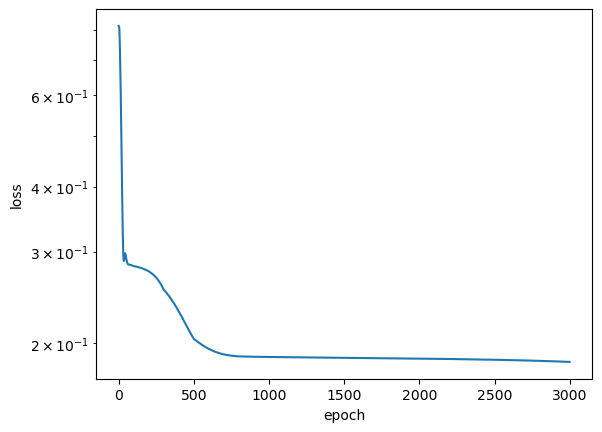

In [ ]:
# plot loss
trainer_metrics = trainer.callbacks[0].metrics
loss = trainer_metrics["train_loss"]
epochs = range(len(loss))
plt.plot(epochs, loss.cpu())
# plotting
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")

# Test NN: Plot errors in output/target features

In [ ]:
all_outputs = None
all_targets = None

trainer.data_module.setup("test")
with torch.no_grad():
    for data in trainer.data_module.test_dataloader():
        inputs, target = data[0][1]["input"], data[0][1]["target"]
        outputs = solver(inputs)
        
        if all_outputs is None:
            all_outputs = LabelTensor(outputs, labels=output_columns)
            all_targets = target
        else:
            all_outputs.append(LabelTensor(outputs, labels=output_columns))
            all_targets.append(target)
        break

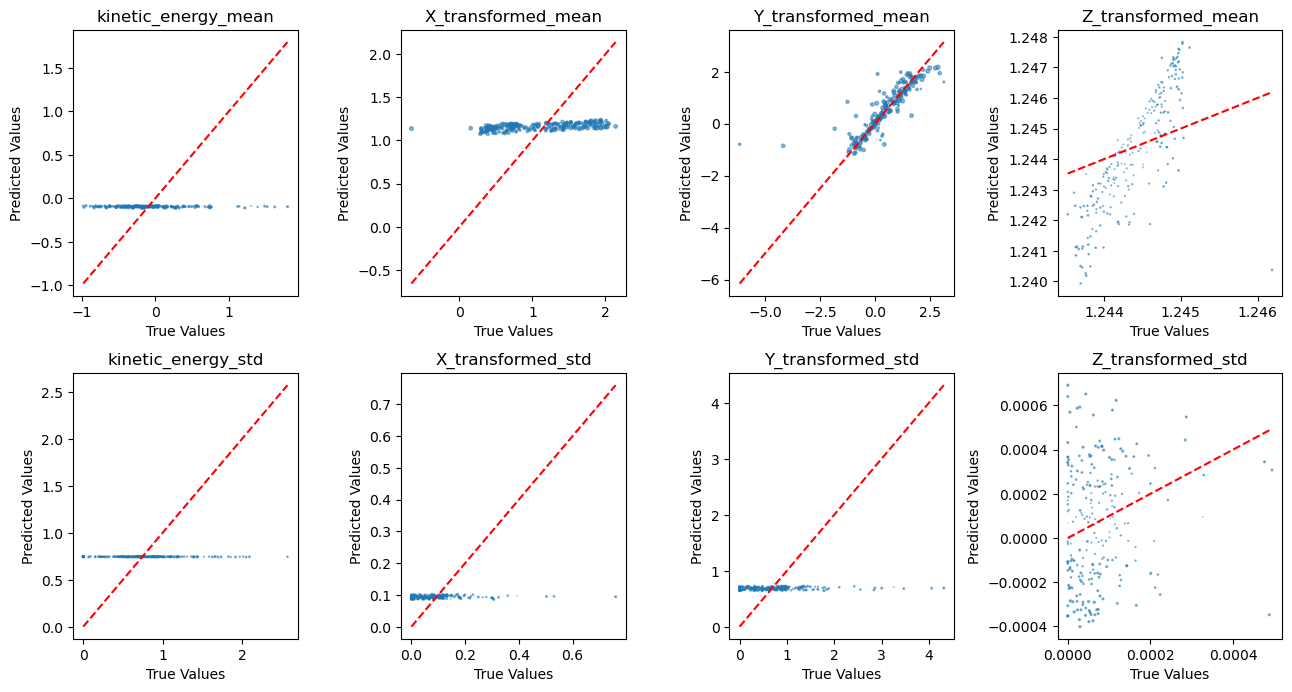

In [ ]:
# plot targets vs predictions for validation set
y_mean, y_std = all_outputs.mean(0).detach(), all_outputs.std(0).detach()
true_output = all_targets.detach()

plt.figure(figsize=(13, 10))
# use 3 columns per row
for i, col in enumerate(output_columns):
    plt.subplot(len(output_columns)//4+1, 4, i+1)
    plt.scatter(true_output[:, i], y_mean[:, i], alpha=0.5, s=10*y_std[:, i]/y_std.max())
    plt.plot([true_output[:, i].min(), true_output[:, i].max()],
             [true_output[:, i].min(), true_output[:, i].max()], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(col)
plt.tight_layout(pad=1.0)
